Given a subset of DNA and the codon elongation rate data, calculate the time (in seconds) the subset will take to be translated.

In [1]:
import numpy as np
import pandas as pd
import matplotlib as plt
import sys
sys.path.append('/Users/ellateasell/Research/CodonUsageBias/code')

from lib.calculations import calculate_elongation_time
from lib.genetic_data_helpers import *
from lib.data_access_helpers import load_fasta_records

In [2]:

############### First get list of SRP dependent and independent genes fomr the secretome ################

path = '../data/srp_dependency.xlsx'
df = pd.read_excel(path)

srp_dep = df.loc[df['srp_dept'] == "SRP dependent"]
srp_dep = srp_dep[['gene', 'secretome', 'srp_dept', 'hydrophobic_features', 'hydrophobic_start']]

srp_indep = df.loc[df['srp_dept'] == "SRP independent"]
srp_indep = srp_indep[['gene', 'secretome', 'srp_dept', 'hydrophobic_features', 'hydrophobic_start']]

print(f"SRP dependent shape: {srp_dep.shape}")
print(f"SRP independent shape: {srp_indep.shape}")

SRP dependent shape: (435, 5)
SRP independent shape: (333, 5)


In [3]:
########### Load the DNA fasta for the genes ##########
path = "../data/orf_genomic_all.fasta"

srp_dep_genes = srp_dep['gene'].to_list()
srp_dep_records = load_fasta_records(path, srp_dep_genes)

indep_genes = srp_indep['gene'].to_list()
indep_records = load_fasta_records(path, indep_genes)
    

In [4]:
def run_elongation_time_analysis(record: SeqRecord, window_size, distance, hydro_start_n):
    
    # TODO: choosing the window location (ie 'cleavage site' and distance) is tricky without very accurate predictions
    # for now, lets just go with 65 codons from the cleavage site to start
    
    extraction = extract_window_and_complement(record, window_size, distance, hydro_start_n)
    
    if extraction is None:
        return 0.0
    else:
        window = extraction[0]
        valid, codons = ensure_valid_orf(window)
    
    if valid:
        return calculate_elongation_time(codons)
    else:
        print(f"Invalid window extraction for {record.id}")
        return 0.0
    

In [5]:
###########
window_size = 21 * 3
distance = 65 * 3

dep_times = []
for record in srp_dep_records:
    gene = record.id
    row = srp_dep[srp_dep['gene'] == gene]
    # get the coordinate of the first hydrophobic region's start
    hydro_start_n = int(row['hydrophobic_start'].iloc[0])
    
    time = run_elongation_time_analysis(record, window_size, distance, hydro_start_n)
    if time != 0.0:
        dep_times.append(time)
    
dep_times_arr = np.array(dep_times)

indep_times = []
for record in indep_records:
    gene = record.id
    row = srp_indep[srp_indep['gene'] == gene]
    # get the coordinate of the first hydrophobic region's start
    hydro_start_n = int(row['hydrophobic_start'].iloc[0])
    
    time = run_elongation_time_analysis(record, window_size, distance, hydro_start_n)
    if time != 0.0:
        indep_times.append(time)
indep_times_arr = np.array(indep_times)
    

Sequence YBL040C length is not a multiple of three.
Sequence YBR058C-A too short for window choice.
Sequence YBR196C-A too short for window choice.
Sequence YBR255C-A length is not a multiple of three.
Sequence YCL005W-A length is not a multiple of three.
Sequence YCL002C length is not a multiple of three.
Sequence YCR024C-B too short for window choice.
Sequence YCR024C-A too short for window choice.
Sequence YDL232W too short for window choice.
Sequence YDL067C too short for window choice.
Sequence YDR276C too short for window choice.
Sequence YDR367W length is not a multiple of three.
Sequence YDR525W-A too short for window choice.
Sequence YEL017C-A too short for window choice.
Sequence YER039C-A too short for window choice.
Sequence YER053C-A too short for window choice.
Sequence YFR032C-B too short for window choice.
Sequence YGL226C-A length is not a multiple of three.
Sequence YGL194C-A too short for window choice.
Sequence YGL041C-B too short for window choice.
Sequence YGR105W

SRP-dependent Statistics:
  Count: 387
  Mean: 3.563
  Std: 0.728
  Median: 3.376

SRP-independent Statistics:
  Count: 311
  Mean: 3.597
  Std: 0.834
  Median: 3.374


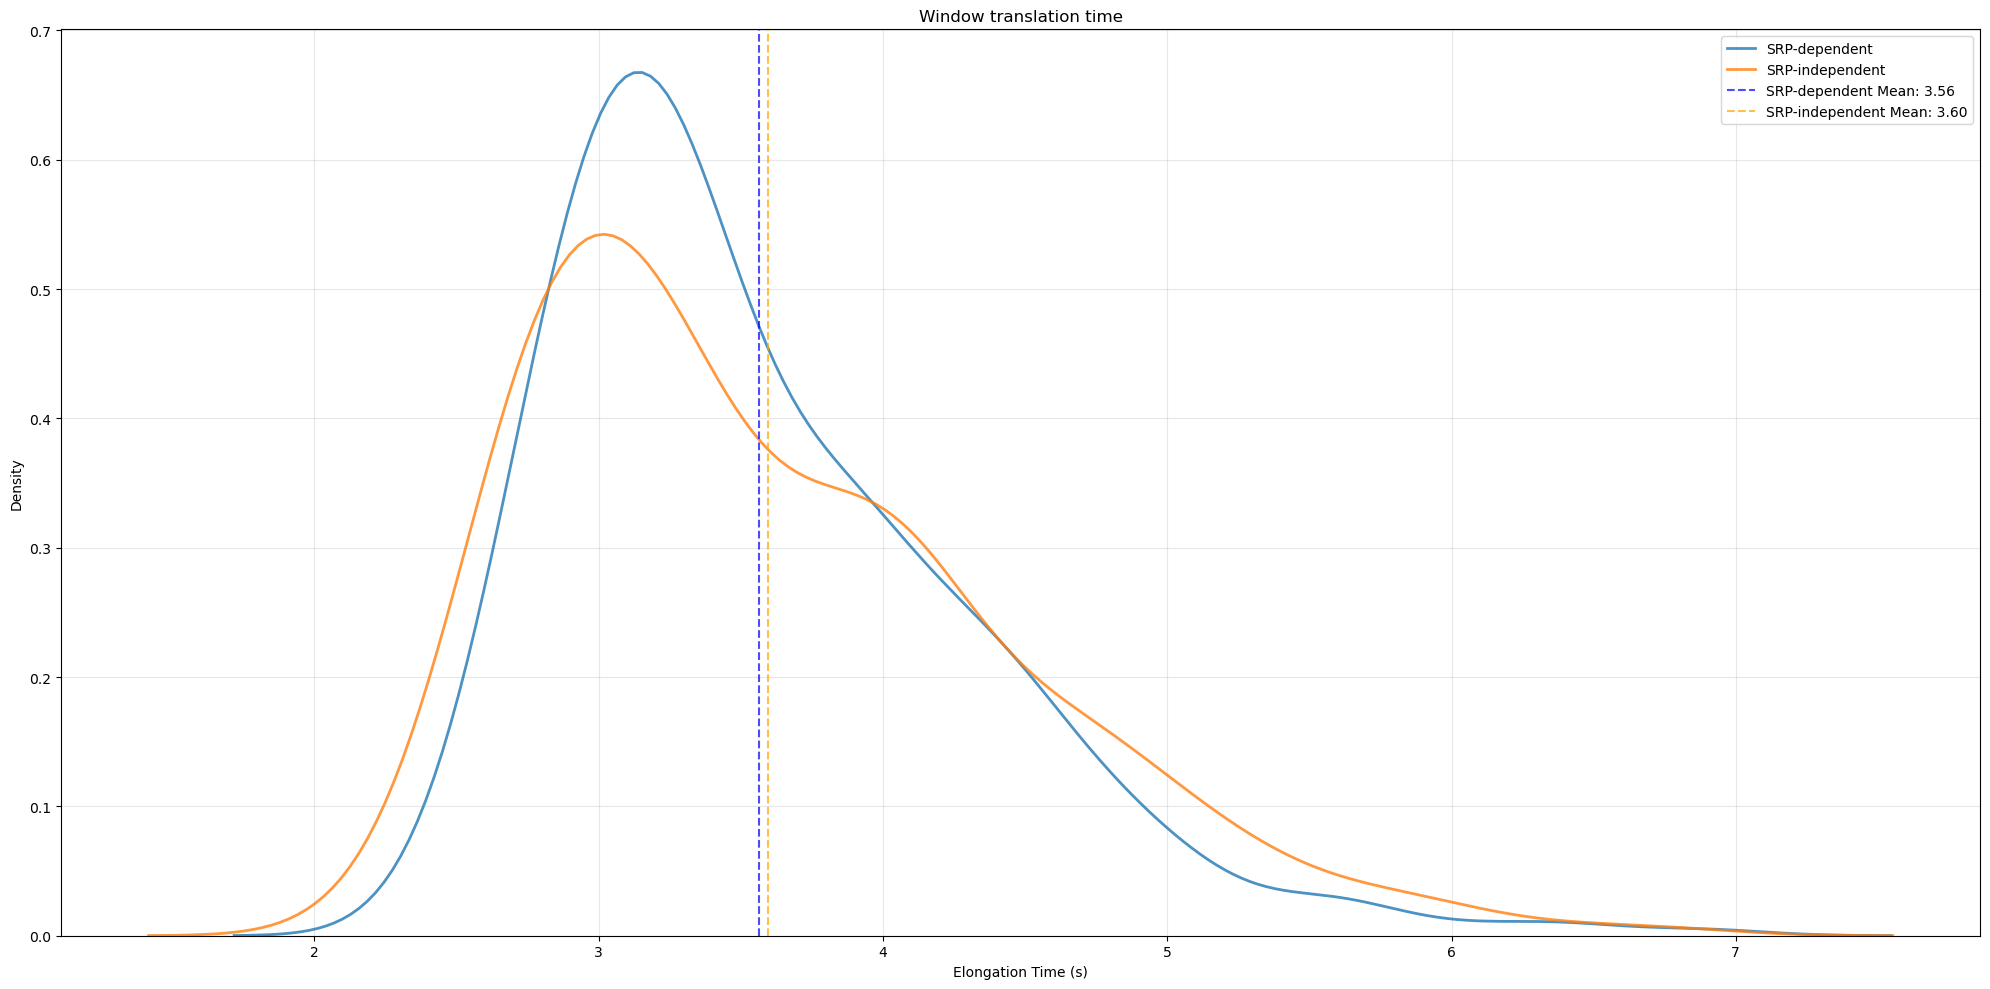

In [6]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(20,10))

# Create KDE plots
sns.kdeplot(dep_times_arr, label="SRP-dependent", linewidth=2, alpha=0.8)
sns.kdeplot(indep_times_arr, label="SRP-independent", linewidth=2, alpha=0.8)

# Add vertical lines for means
mean1 = np.mean(dep_times_arr)
mean2 = np.mean(indep_times_arr)
plt.axvline(mean1, color='blue', linestyle='--', alpha=0.7, label=f'SRP-dependent Mean: {mean1:.2f}')
plt.axvline(mean2, color='orange', linestyle='--', alpha=0.7, label=f'SRP-independent Mean: {mean2:.2f}')

# Customize the plot
plt.xlabel('Elongation Time (s)')
plt.ylabel('Density')
plt.title('Window translation time')
plt.legend()
plt.grid(True, alpha=0.3)

# Print summary statistics
print(f"SRP-dependent Statistics:")
print(f"  Count: {len(dep_times_arr)}")
print(f"  Mean: {mean1:.3f}")
print(f"  Std: {np.std(dep_times_arr):.3f}")
print(f"  Median: {np.median(dep_times_arr):.3f}")

print(f"\nSRP-independent Statistics:")
print(f"  Count: {len(indep_times_arr)}")
print(f"  Mean: {mean2:.3f}")
print(f"  Std: {np.std(indep_times_arr):.3f}")
print(f"  Median: {np.median(indep_times_arr):.3f}")

plt.tight_layout()
plt.show()

SRP-dependent Statistics:
  Count: 387
  Mean: 3.563
  Std: 0.728
  Median: 3.376

SRP-independent Statistics:
  Count: 311
  Mean: 3.597
  Std: 0.834
  Median: 3.374


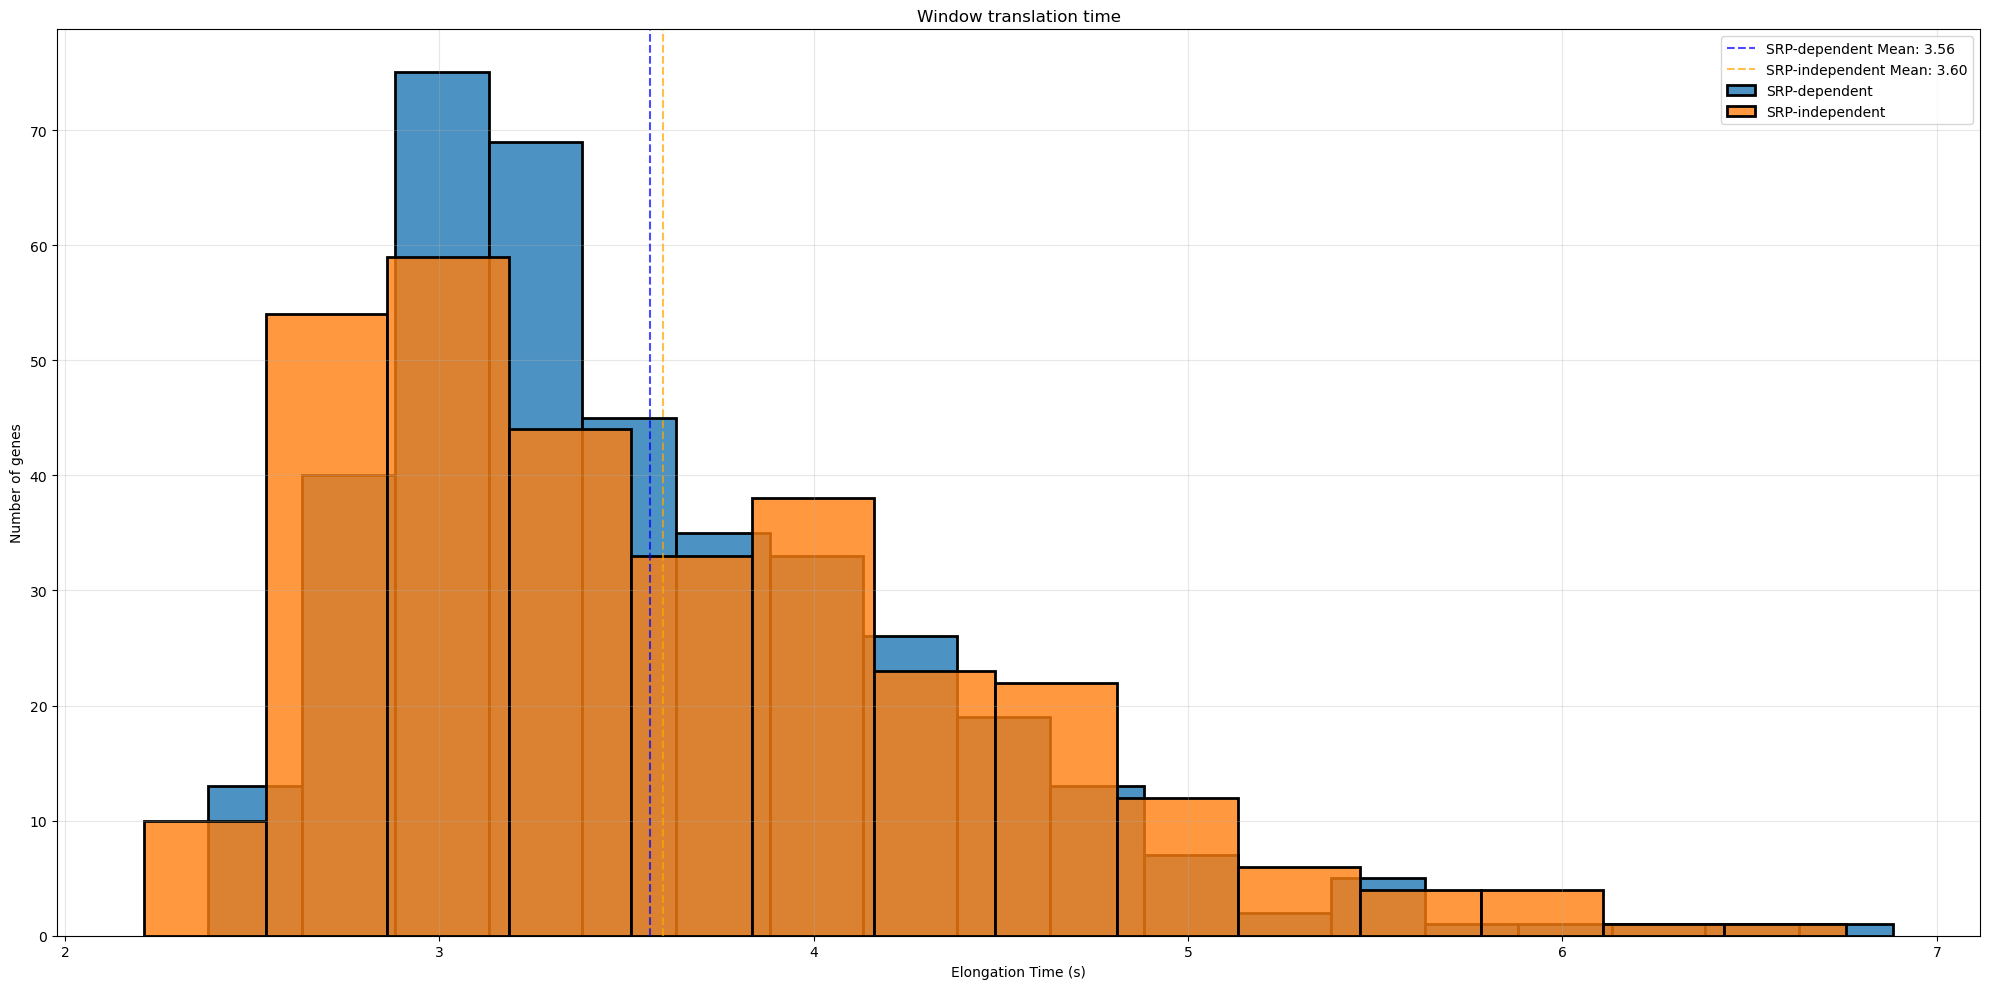

In [8]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(20,10))

# Create KDE plots
sns.histplot(dep_times_arr, label="SRP-dependent", linewidth=2, alpha=0.8)
sns.histplot(indep_times_arr, label="SRP-independent", linewidth=2, alpha=0.8)

# Add vertical lines for means
mean1 = np.mean(dep_times_arr)
mean2 = np.mean(indep_times_arr)
plt.axvline(mean1, color='blue', linestyle='--', alpha=0.7, label=f'SRP-dependent Mean: {mean1:.2f}')
plt.axvline(mean2, color='orange', linestyle='--', alpha=0.7, label=f'SRP-independent Mean: {mean2:.2f}')

# Customize the plot
plt.xlabel('Elongation Time (s)')
plt.ylabel('Number of genes')
plt.title('Window translation time')
plt.legend()
plt.grid(True, alpha=0.3)

# Print summary statistics
print(f"SRP-dependent Statistics:")
print(f"  Count: {len(dep_times_arr)}")
print(f"  Mean: {mean1:.3f}")
print(f"  Std: {np.std(dep_times_arr):.3f}")
print(f"  Median: {np.median(dep_times_arr):.3f}")

print(f"\nSRP-independent Statistics:")
print(f"  Count: {len(indep_times_arr)}")
print(f"  Mean: {mean2:.3f}")
print(f"  Std: {np.std(indep_times_arr):.3f}")
print(f"  Median: {np.median(indep_times_arr):.3f}")

plt.tight_layout()
plt.show()